# Logistic Regression

##### Libraries

In [1]:
## Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy.stats as ss

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

## Goals of this lecture
 
- Introduction to **classification**.  
- Foundations of **logistic regression**.
   - "Generalizing" the linear model.
   - Log-odds and the logistic function.
- Implementing logistic regression in `statsmodels`.

## What is classification?

> In statistical modeling, **classification** refers the problem of predicting a *categorical* response variable $Y$ using some set of features $X$.

There are many examples of *categorical* responses:

- Is an email `spam` or `not spam`?  
- Is a cell mass `cancer` or `not cancer`?  
- Will this customer `buy` or `not buy` the product?  
- Is a credit card `fraudulent` or `not fraudulent`?
- Is this a picture of a `cat`, a `dog`, a `person`, or `other`? 

Before we discuss *how* to do this, it's important to reflect on what exactly a "category" is.

### "To classify is human"

> "**To classify is human**...We sort dirty dishes from clean, white laundry from colorfast, important email
to be answered from e-junk.... Any part of the home, school, or workplace reveals some such system of classification: medications classed as not for children occupy a higher shelf than safer ones; books for reference are shelved close to where we do the Sunday crossword puzzle; door keys are color-coded and stored according to frequency of use."  
 -[Bowker & Star, 2000](https://direct.mit.edu/books/book/4738/chapter/216477/Introduction-To-Classify-Is-Human)



We often **impose** a category structure onto the world––as needed––and these categories in turn can have **real impact** on our lives.
 
- E.g., whether a behavior is diagnosed as a `mental illness`.  
- E.g., whether the census includes *multiple options* for `ethnicity`. 

#### Check-in

What aspects of your life involve **category structure**? Which ones do you think have the "right" category structure, and why do you think that?

### Categories and the problem of *measurement*

The issue of *which* categories are "correct" is an instance of more general questions around **measurement** and [**construct validity**](https://en.wikipedia.org/wiki/Construct_validity).

As we discuss the practical task of *classifying* data, there are important questions to keep in mind:

- Where is the **boundary** drawn between categories?  
- Who **decides** the category structure?
- What **function** do these categories serve?
- What variance is **obscured** by these categories? What is **illuminated**?  

And remember that [the map is not the territory](https://en.wikipedia.org/wiki/Map%E2%80%93territory_relation).

### How many categories?

- One question is *how many categories* there are.  
- **Binary classification** involves sorting inputs $X$ into one of two labels.
   - E.g., `spam` vs. `not spam`. 
- But many classification tasks involve more than two labels.
   - E.g., *face recognition* involves $N$ categories, where $N =$ number of possible identities.

## Foundations of logistic regression

[Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) is a widely used approach for modeling **binary, categorical data**.

To understand logistic regression, we'll have to dive into the theoretical foundations of the **logistic function**.

### Example dataset: `spam`

As we learn logistic regression, we'll start with a dataset about different emails, with information about which ones were considered `spam`.

In [3]:
df_spam = pd.read_csv("data/models/classification/email.csv")
df_spam.head(3)

,spam,to_multiple,from,cc,sent_email,time,image,attach,dollar,winner,...,viagra,password,num_char,line_breaks,format,re_subj,exclaim_subj,urgent_subj,exclaim_mess,number
0,0,0,1,0,0,2012-01-01T06:16:41Z,0,0,0,no,...,0,0,11.370,202,1,0,0,0,0,big
1,0,0,1,0,0,2012-01-01T07:03:59Z,0,0,0,no,...,0,0,10.504,202,1,0,0,0,1,small
2,0,0,1,0,0,2012-01-01T16:00:32Z,0,0,4,no,...,0,0,7.773,192,1,0,0,0,6,small


### Why not linear regression?

The `spam` variable is coded as `0` (no) or `1` (yes). 

- In principle, we *could* treat this a continuous variable, and model `spam` using linear regression.  
- We could interpret our prediction $\hat{y}$ as the *probability* of the outcome.

**Does anyone see any issues with this?**

#### Going beyond $[0, 1]$

A *linear* model will generate predictions beyond $[0, 1]$, even though **probability** should be bounded at $[0, 1]$.

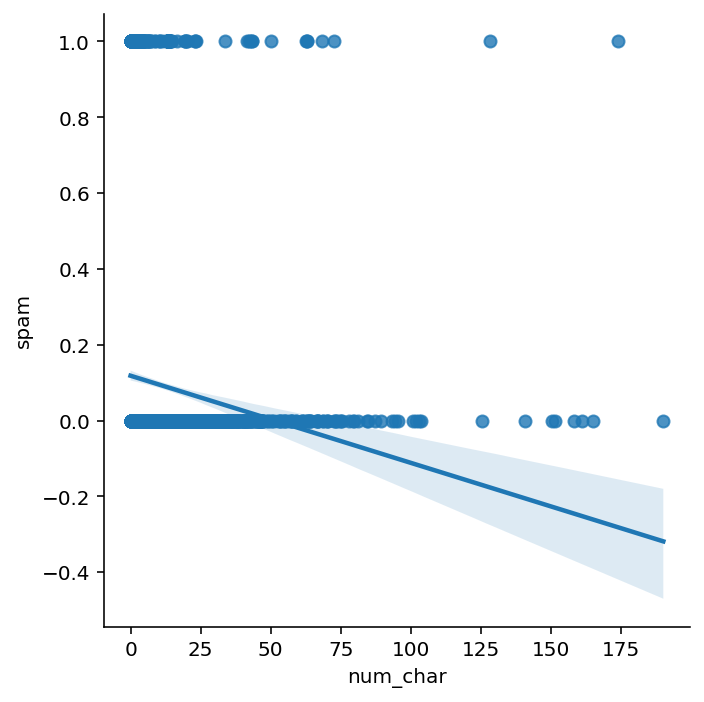

In [4]:
sns.lmplot(data = df_spam, x = "num_char", y = "spam")

### Framing the problem probabilistically

We want to **sort** input into different labels, so it's helpful to think of this **probabilistically**.

- Treat each outcome as **Bernoulli trials**, i.e., "success" (`spam`) and "failure" (`not spam`).  
- Each observation has an independent probability of success, $p_i$.  
 - On its own, this is just be the **proportion of spam emails**, i.e., $p(spam)$. 
- Our goal is to **model** $p_i$ *conditioned* on other variables that might relate to $p_i$.

#### Check-in

On its own, $p_i$ is just the probability of `success` (e.g., `spam`). What does this remind you of from *linear regression*?

#### Solution

On its own, the probability of `success` is most analogous to an `Intercept`-only model in linear regression––i.e., the *mean* of $Y$.

### Generalizing the linear model (GLMs)

> [**Generalized linear models** (GLMs)](https://en.wikipedia.org/wiki/Generalized_linear_model) are generalizations of linear regression. 

Each GLM has:

- A **probability distribution** representing the *generative* model for the outcome variable.  
- A **linear model**: $\eta = \beta_0 + \beta_1X_1 + ... + \beta_nX_n$
- A **link function** relating the linear model to the outcome we're interested in. 

We can design a function that *links* the linear model to a probability score, i.e., $[0, 1]$. 

#### Quick tour of GLMs

There are many different kinds of **generalized linear models**. Some of the most common are:

|Model name|Distribution|Link name|Use cases|Example|
|---------|------------|---------|--------|--------|
|Ordinary linear regression|Normal distribution|Identity|Linear response data|`Height`, `Price`|
|Logistic regression|Bernoulli/Binomial|[Logit](https://en.wikipedia.org/wiki/Logit)|Binary response data|`spam`, `fraud`|
|Poisson regression|Poisson|[Log](https://en.wikipedia.org/wiki/Natural_logarithm)|Count data|`#words`, `#visitors`|

We'll be focusing on **logistic regression**.

### Logistic regression

- Logistic regression uses a **logit link function**.  

$\Large logit(p) = log(\frac{p}{1 - p})$  


- Where $p$ is the probability of some outcome.
- Takes a value between $[0, 1]$ and maps it to a value between $[-\infty, \infty]$.  
- Also called the **log odds**.  

#### Introducing the *odds*

> The **odds** of an event are the ratio of the probability of the event occurring, $p(y)$, to the probability of the event not occuring, $1 - p(y)$.

$Odds(p) = \Large \frac{p}{1 - p}$

Unlike $p$, the **odds** are bounded at $[0, \infty]$.

Text(0.5, 1.0, 'Odds(y) vs. P(y)')

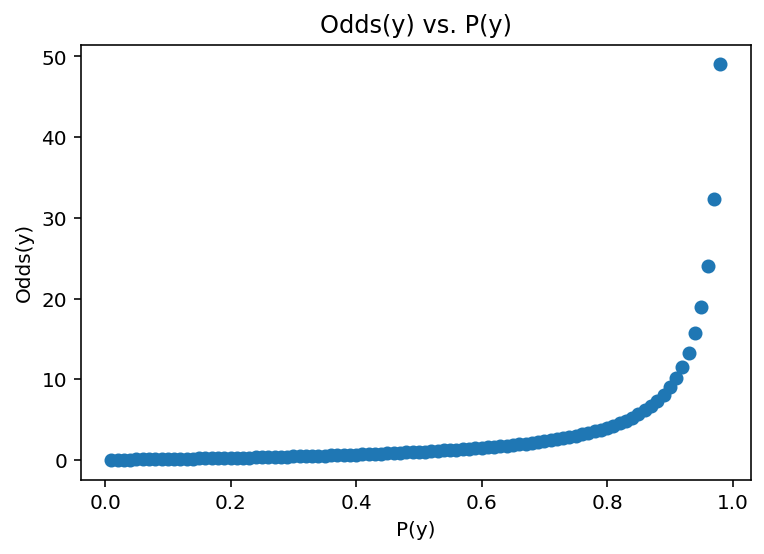

In [5]:
p = np.arange(.01, .99, .01)
odds = p / (1 - p)
plt.scatter(p, odds)
plt.xlabel("P(y)")
plt.ylabel("Odds(y)")
plt.title("Odds(y) vs. P(y)")

#### Introducing the *log-odds*

> The **log-odds** of an event is the **log** of the odds of that event. This is also called the **logit** function.

$Logit(p) = log(\frac{p}{1 - p})$

Unlike $p$, the **log-odds** are bounded at $[-\infty, \infty]$.

Text(0.5, 1.0, 'Log-odds(y) vs. P(y)')

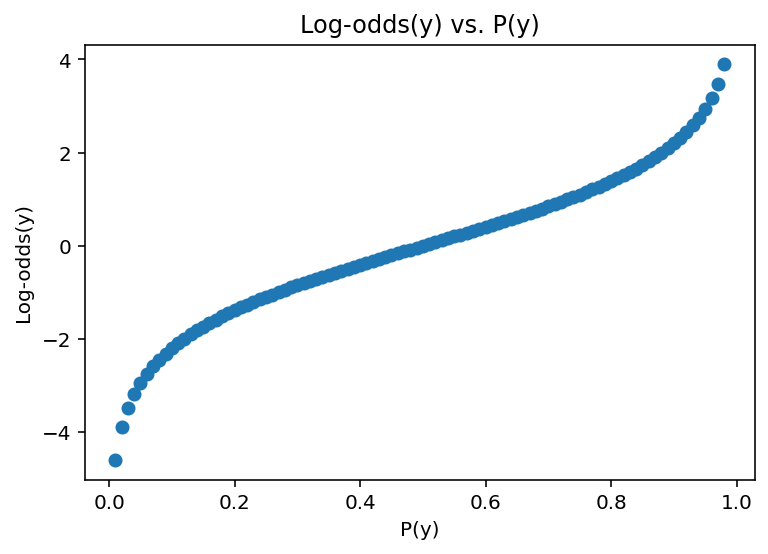

In [6]:
lo = np.log(p / (1 - p))
plt.scatter(p, lo)
plt.xlabel("P(y)")
plt.ylabel("Log-odds(y)")
plt.title("Log-odds(y) vs. P(y)")

#### Check-in

Would the log-odds of $p(y) = .6$ be *positive* or *negative*?

#### Interpreting the *sign* of log-odds

The **sign** of log-odds can be interpreted as reflecting whether $p(y) > .5$ (positive) or $p(y) < .5$ (negative).

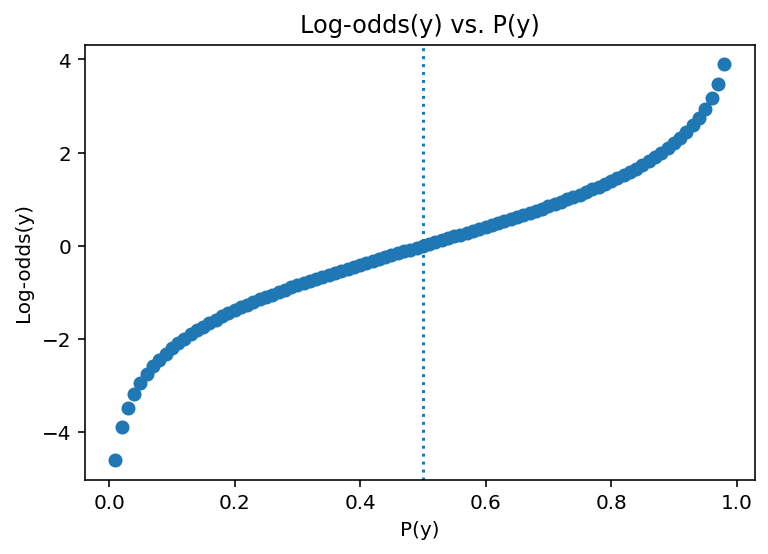

In [7]:
plt.scatter(p, lo)
plt.xlabel("P(y)")
plt.ylabel("Log-odds(y)")
plt.title("Log-odds(y) vs. P(y)")
plt.axvline(x = .5, linestyle = "dotted")

#### Check-in

Is `log-odds(y)` *linearly related* to `p(y)`? Why does this matter?

#### A *non-linear relationship*

- The **log-odds** of $y$ is non-linearly related to the **probability** of $y$.  
- This means that we *can't* interpret linear changes in *log-odds* as linear changes in *probability*.
   - That will be very important when we build logistic regression models.

### Introducing the *logistic function*

> The [**logistic function**](https://en.wikipedia.org/wiki/Logistic_function) is the *inverse* of the logit function. It converts the *log-odds* back to *probability*.

The logistic function is defined as:

$\Large \frac{e^x}{1 + e^x}$  

Where $x$ is the **log-odds** of an event.

#### Check-in

Would applying the logistic function to a log-odds of `1` yield a $p >.5$ or $p < .5$?

In [8]:
### Your code here

#### Mapping from log-odds to $p$

We can use `np.exp(x)` to compute $e^x$.

In [9]:
lo = 1
p = np.exp(lo) / (np.exp(lo) + 1)
p ### p is > .5

0.7310585786300049

#### A more general mapping

Text(0.5, 1.0, 'Log-odds(Y) vs. P(Y)')

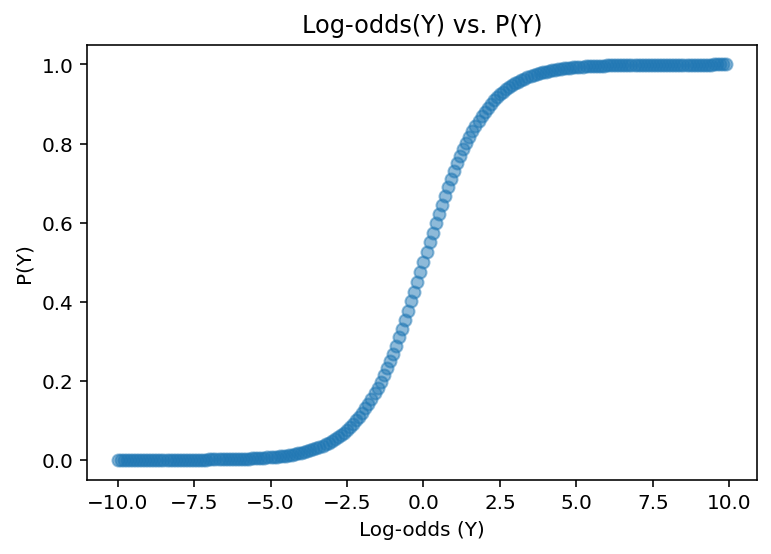

In [10]:
log_odds = np.arange(-10, 10, .1)
p = np.exp(log_odds) / (1 + np.exp(log_odds))
plt.scatter(log_odds, p, alpha = .5)
plt.xlabel("Log-odds (Y)")
plt.ylabel("P(Y)")
plt.title("Log-odds(Y) vs. P(Y)")

### Where does *regression* come into play?

With logistic regression, we learn **parameters** $\beta_0, ..., \beta_n$ for the following equation:

$\Large log(\frac{p}{1 - p}) = \beta_0 + \beta_1X_1 + \epsilon$

- Our "dependent variable" is technically the **log-odds** (logit) of $p$.  
- Thus, we are learning a **linear relationship** between $X$ and the **log-odds** of our outcome.

#### Check-in

Based on this formulation:

$log(\frac{p}{1 - p}) = \beta_0 + \beta_1X_1 + \epsilon$

How would we interpret $\beta_1 = 1$ with respect to **log odds**?

#### Log-odds ~ $X$ is linear

- There is a straightforward linear interpretation between our parameters $\beta_0, ..., \beta_n$ and the **log-odds** of our outcome.
- That is, if $\beta_1=1$:
   - For each 1-unit increase in $X$, the **log-odds** of our outcome increases by $1$.
- If $\beta_1 = 2$:
   - For each 1-unit increase in $X$, the **log-odds** of our outcome increases by $2$.



#### Check-in

Based on this formulation:

$log(\frac{p}{1 - p}) = \beta_0 + \beta_1X_1 + \epsilon$

How would we interpret $\beta_1 = 1$ with respect to **probability**?

####  $p$ ~$X$ is *not* linear

> The mapping between **log-odds** and $p(y)$ is **not linear**.

- This means that we can't interpret our coefficients *linearly* with respect to $p$.  

Text(0.5, 1.0, 'Log-odds(Y) vs. P(Y)')

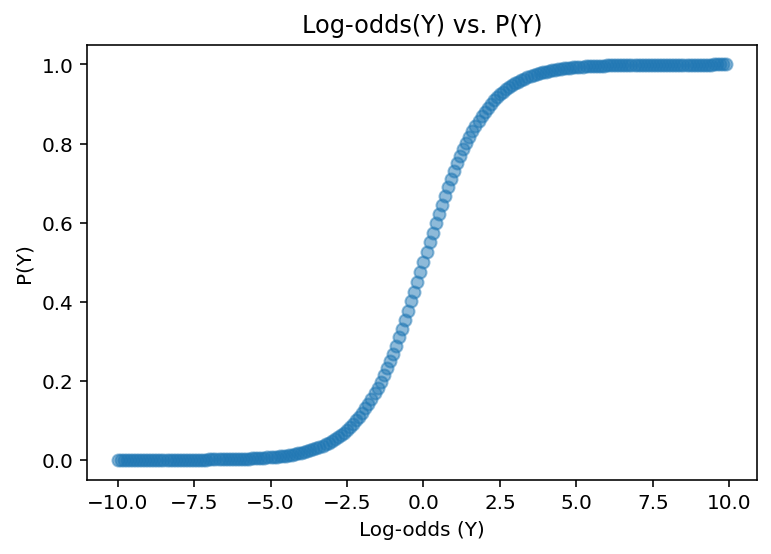

In [11]:
log_odds = np.arange(-10, 10, .1)
p = np.exp(log_odds) / (1 + np.exp(log_odds))
plt.scatter(log_odds, p, alpha = .5)
plt.xlabel("Log-odds (Y)")
plt.ylabel("P(Y)")
plt.title("Log-odds(Y) vs. P(Y)")

## Logistic regression in Python

To perform logistic regression in Python, we can use the `statsmodels` package, which has the `logit` method.

```python
smf.logit(data = df_name, formula = "y ~ x").fit()
```

Fitting the models is relatively straightforward––the hard(er) part is interpreting them.

### Fitting the model

To start, let's fit a model predicting `spam` from `num_char` (i.e., how long the message is).

In [14]:
mod_len = smf.logit(data = df_spam, formula = "spam ~ num_char").fit()
mod_len.summary()

Optimization terminated successfully.
         Current function value: 0.299210
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   spam   No. Observations:                 3921
Model:                          Logit   Df Residuals:                     3919
Method:                           MLE   Df Model:                            1
Date:                Fri, 03 Mar 2023   Pseudo R-squ.:                 0.03725
Time:                        10:17:24   Log-Likelihood:                -1173.2
converged:                       True   LL-Null:                       -1218.6
Covariance Type:            nonrobust   LLR p-value:                 1.607e-21
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7987      0.072    -25.135      0.000      -1.939      -1.658
num_char      -0.0621      0.008     -7.746      0.000      -0.078      -0.046
==============================================================================
"""

### Interpreting the model

In this simple model, we can interpret the coefficients as follows:

- `Intercept`: the *log-odds* of an email being `spam` when `num_char == 0`.
- `num_char`: for every 1-unit increase in `num_char`, how does the *log-odds* of an email being `spam` change?

$Y = -1.8 - 0.06*X_{length} + \epsilon$

In [21]:
mod_len.params

Intercept   -1.798738
num_char    -0.062071
dtype: float64

#### Check-in

Based on these coefficients, what is the predicted **probability** of an utterance being spam when `num_char == 0`?

In [22]:
### Your code here

#### Deriving $p$ using logistic function

To calculate $p(y)$, we need to convert log-odds back to probability.

In [23]:
log_odds = -1.8 # Just the intercept
p = np.exp(log_odds) / (1 + np.exp(log_odds))
p

0.1418510649004878

#### Check-in

Based on these coefficients, what is the predicted **probability** of an utterance being spam when `num_char == 100`?

In [24]:
### Your code here

#### Deriving $p$ (pt. 2)

Here, we need to:

- Calculate log-odds by inputting $X$ into the equation.  
- Convert log-odds back to probability using the **logistic** function.

In [25]:
log_odds = -1.8 - 0.06 * 100
p = np.exp(log_odds) / (1 + np.exp(log_odds))
p

0.00040956716498605043

#### Log-odds != probability

Text(0.5, 0, 'P(spam)')

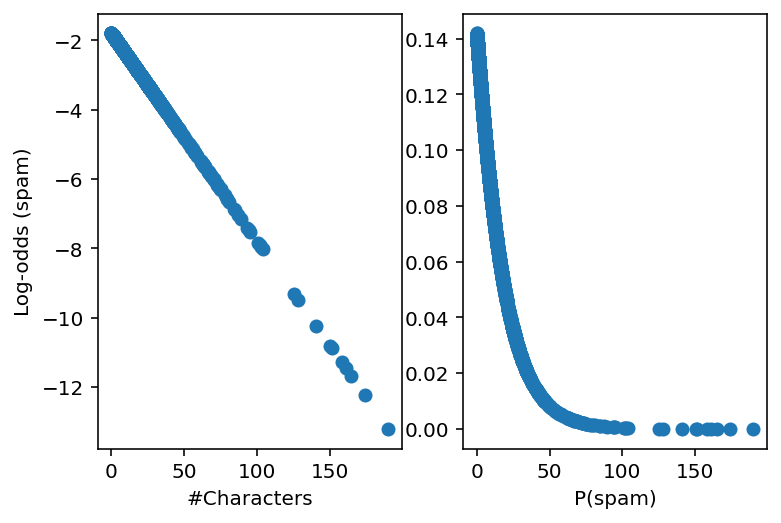

In [42]:
X = df_spam['num_char']
lo = -1.8 - .06 * X
p = np.exp(lo) / (1 + np.exp(lo))
fig, axes = plt.subplots(1, 2)
axes[0].scatter(X, lo)
axes[1].scatter(X, p)
axes[0].set_xlabel("#Characters")
axes[1].set_xlabel("#Characters")
axes[0].set_ylabel("Log-odds (spam)")
axes[1].set_xlabel("P(spam)")

### Logistic regression with categorical predictors

Instead of using `num_char` (a continuous predictor), we can use a categorical predictor (like `winner`: whether or not an email has the word "winner").

In [43]:
mod_winner = smf.logit(data = df_spam, formula = "spam ~ winner").fit()
mod_winner.summary()

Optimization terminated successfully.
         Current function value: 0.307661
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   spam   No. Observations:                 3921
Model:                          Logit   Df Residuals:                     3919
Method:                           MLE   Df Model:                            1
Date:                Fri, 03 Mar 2023   Pseudo R-squ.:                 0.01005
Time:                        11:18:58   Log-Likelihood:                -1206.3
converged:                       True   LL-Null:                       -1218.6
Covariance Type:            nonrobust   LLR p-value:                 7.410e-07
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.3140      0.056    -41.121      0.000      -2.424      -2.204
winner[T.yes]     1.5256      0.275      5.538      0.000       0.986       2.066
=================================================================================
"""

#### Check-in

How should we interpret the **parameters** of this model? 

In [44]:
### Your code here

#### Interpreting $\beta$ for categorical predictors

As with *linear regression*, the $\beta$ for a categorical predictor means **predicted change in log-odds relative to the `Intercept`**

- Here, $\beta_0$ is the **predicted log-odds** when `winner == no`.  
- $\beta_1 is the **predicted change in log-odds** (relative to the `Intercept`) when `winner == yes`.


In [46]:
mod_winner.params

Intercept       -2.314047
winner[T.yes]    1.525589
dtype: float64

#### Check-in

According to the model, what is $p(spam)$ for emails that don't have the word `winner`?

In [47]:
### Your code here

#### Solution

In [48]:
lo = mod_winner.params['Intercept']
np.exp(lo) / (np.exp(lo) + 1)

0.08996629504796422

#### Check-in

According to the model, what is $p(spam)$ for emails that **do** have the word `winner`?

In [49]:
### Your code here

#### Solution

In [51]:
lo = mod_winner.params['Intercept'] + mod_winner.params['winner[T.yes]']
np.exp(lo) / (np.exp(lo) + 1)

0.31250000000000006

### Generating predictions

By default, `predict()` will generate predicted $p$.

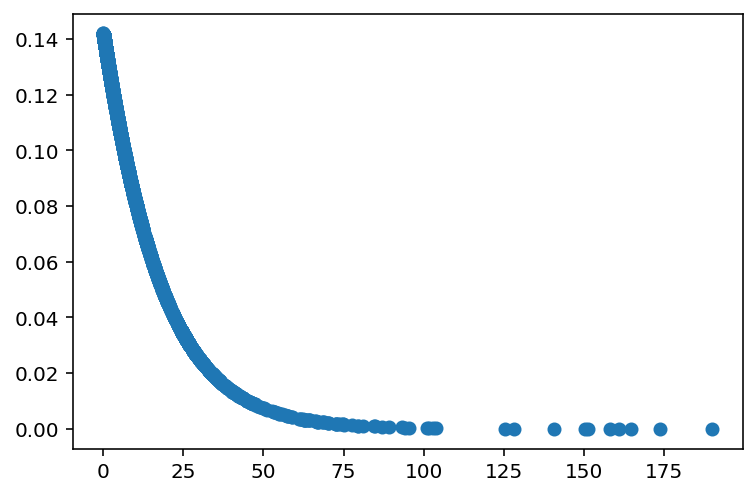

In [53]:
plt.scatter(df_spam['num_char'], mod_len.predict())

## Conclusion

- Many use-cases of statistical modeling involve a **categorical** response variable.
- **Logistic regression** can be used for binary classication tasks.
   - Logistic regression is a **generalized linear model** (GLM).
   - Predicts the *log-odds* of $Y$ as a linear function of $X$.
   - Log-odds can be converted to $p$ using the **logistic function**.